# Basic Network Analysis Tutorial - Centroid and Distance Analysis

##### The purpose of this tutorial is to learn to calculate distances between two points for an area. This helps us assign distance thresholds which is required for our food desert analysis

In [12]:
# ignoring unwanted messages

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Import Modules

In [5]:
import pandas as pd # manipulating datasets
import geopandas as gpd
import matplotlib.pyplot as plt # plotting module
from matplotlib import cm
from matplotlib.colors import Normalize
import os
import requests # requesting data from the web 

import folium # mapping module
from folium.features import DivIcon
import numpy as np # numbers

#### Importing Network Analysis Modules

In [7]:
import networkx as nx
import osmnx as ox

In [10]:
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic

### Fetch the Data for a particular Area. 

In [8]:
graph = ox.graph_from_place("West Lafayette, Indiana", network_type="drive") # change to desired city

In [ ]:
ox.save_graphml(graph, filepath="westlafayette_indiana_network.graphml") # save the graph so that you do not need to download it again

In [ ]:
# graph = ox.load_graphml("westlafayette_indiana_network.graphml") # load the graph up if saved

### Know your Area

In [33]:
# Basic network statistics
num_nodes = graph.number_of_nodes()
num_edges = graph.number_of_edges()
avg_degree = sum(dict(graph.degree()).values()) / num_nodes
density = nx.density(graph)

In [47]:
# Print statistics
print(f"Network Statistics for West Lafayette, Indiana:")
print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")
print(f"Average Degree: {avg_degree:.2f}") # 2 decimal places
print(f"Network Density: {density:.6f}") # 6 decimal places

Network Statistics for West Lafayette, Indiana:
Number of Nodes: 1072
Number of Edges: 2641
Average Degree: 4.93
Network Density: 0.002300


In [44]:
# Additional osmnx-specific stats
stats = ox.basic_stats(graph)
print(f"Average Street Length: {stats['street_length_avg']:.2f} meters")
print(f"Total Street Length: {stats['street_length_total']:.2f} meters")

Average Street Length: 146.94 meters
Total Street Length: 223052.15 meters


### Check Layout of the city

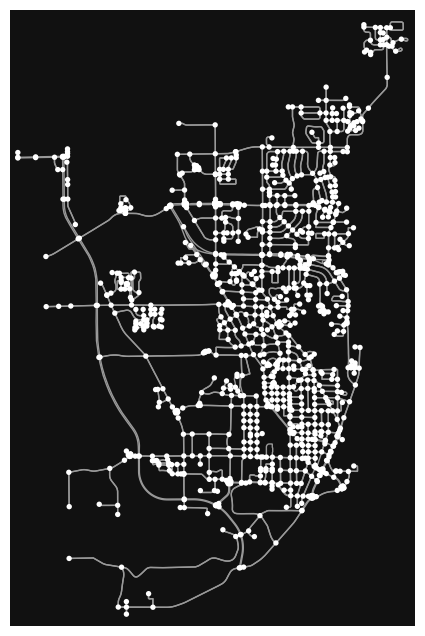

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
ox.plot_graph(graph)

### Get info on points of interests for the city. 
#### This would be break points and roads etc. 

In [13]:
nodes.head()

y          x  street_count         highway  \
osmid                                                          
37968509  40.465347 -86.903994             3             NaN   
37968511  40.465105 -86.904711             1  turning_circle   
37968547  40.422078 -86.914997             4             NaN   
37968548  40.422099 -86.915996             3             NaN   
37968551  40.422362 -86.913771             3             NaN   

                            geometry  
osmid                                 
37968509  POINT (-86.90399 40.46535)  
37968511   POINT (-86.90471 40.4651)  
37968547    POINT (-86.915 40.42208)  
37968548     POINT (-86.916 40.4221)  
37968551  POINT (-86.91377 40.42236)

#### Nodes are used to calculate distances between different nodes. 

<Axes: >

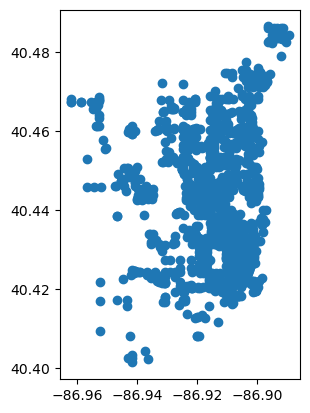

In [16]:
nodes.plot()

In [17]:
edges.head()

osmid      highway            name  oneway reversed  \
u        v        key                                                          
37968509 37968511 0    5326999  residential      Clay Court   False    False   
         38042319 0    5335551  residential  Elkhart Street   False    False   
         38037130 0    5335551  residential  Elkhart Street   False     True   
37968511 37968509 0    5326999  residential      Clay Court   False     True   
37968547 37968552 0    5331462  residential      Hort Drive   False     True   

                           length  \
u        v        key               
37968509 37968511 0     66.342431   
         38042319 0    329.725176   
         38037130 0    100.425056   
37968511 37968509 0     66.342431   
37968547 37968552 0     34.863839   

                                                                geometry  \
u        v        key                                                      
37968509 37968511 0    LINESTRING (-86.90399 40.46535, -86.90471 40.4...   
         38042319 0    LINESTRING (-86.90399 40.46535, -86.90412 40.4...   
         38037130 0    LINESTRING (-86.90399 40.46535, -86.90392 40.4...   
37968511 37968509 0    LINESTRING (-86.90471 40.4651, -86.90399 40.46...   
37968547 37968552 0    LINESTRING (-86.915 40.42208, -86.91498 40.42239)   

                      maxspeed lanes  ref bridge junction access  
u        v        key                                             
37968509 37968511 0        NaN   NaN  NaN    NaN      NaN    NaN  
         38042319 0        NaN   NaN  NaN    NaN      NaN    NaN  
         38037130 0        NaN   NaN  NaN    NaN      NaN    NaN  
37968511 37968509 0        NaN   NaN  NaN    NaN      NaN    NaN  
37968547 37968552 0     20 mph   NaN  NaN    NaN      NaN    NaN

#### The road network between the nodes

<Axes: >

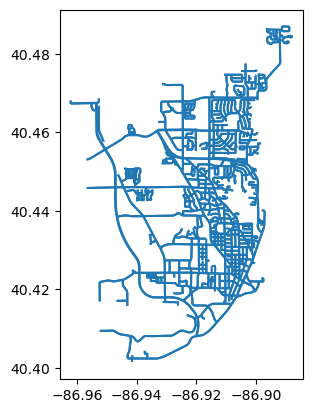

In [20]:
edges.plot()

### Map the POIs

In [22]:
graph = ox.add_edge_speeds(graph)

In [26]:
graph = ox.add_edge_travel_times(graph)  # this is to added travel times based on distance between nodes

### Look up any random coordinate in West Lafayette and find the Nearest Node to that Coordinate. 

##### Imagine this as grocery store. 

In [28]:
coords = (40.469946, -86.956774) # replace this location you want to path to center of the city
random_node = ox.nearest_nodes(graph, X=coords[1], Y=coords[0])
print(random_node)

3547246489


### Highlight that node

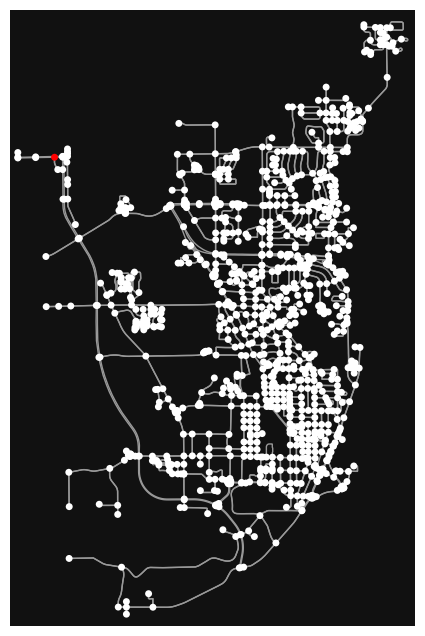

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [30]:
node_colors = ['red' if node == random_node else 'white' for node in graph.nodes()]
ox.plot_graph(graph, node_size=25, node_color=node_colors)

In [48]:
# using multi source is faster when processing multiple nodes

In [32]:
distances = nx.single_source_dijkstra_path_length(graph,
                                                  random_node,
                                                  weight="travel_time")

In [34]:
nx.set_node_attributes(graph, distances, "time2nhb")

### A cool way to generate a heat map of distance from the highlighted node for the whole city

#### Sometimes a node maybe missing a value, we can assign them 0 so to avoid potential errors. Or ignore them completely. 

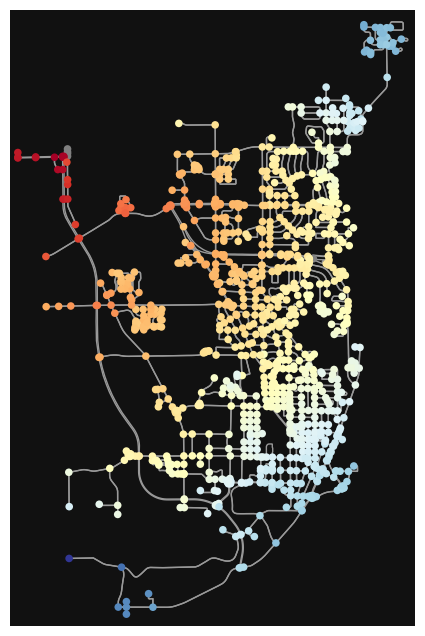

In [38]:
# Get node attributes
attr_values = nx.get_node_attributes(graph, "time2nhb")
nodes = list(graph.nodes())
# Only include nodes with the attribute
node_values = [attr_values[node] for node in nodes if node in attr_values]

# Normalize the values to the range [0, 1]
norm = Normalize(vmin=min(node_values), vmax=max(node_values), clip=True)
normalized_values = norm(node_values)

# Get a colormap
colormap = cm.get_cmap('RdYlBu')

# Apply the colormap to the normalized values
node_colors = colormap(normalized_values)

# Plot the graph with node colors, only for nodes with attributes
fig, ax = ox.plot_graph(graph, node_color=[colormap(norm(attr_values.get(node))) if node in attr_values else 'gray' for node in graph.nodes()], node_size=30)
plt.show()

### The closest nodes to that random node/coordinates is marked is red and as you go further away the color changes to blue

### Calculate the Centroid (the centermost node of the area of interest)

In [41]:
# Extract node positions and calculate the centroid
node_positions = np.array([[data['x'], data['y']] for _, data in graph.nodes(data=True)])
centroid = node_positions.mean(axis=0)
centroid_node = ox.nearest_nodes(graph, X=centroid[0], Y=centroid[1])

In [43]:
# Calculate travel distance and time from the centroid to the specified coordinates
travel_time_from_centroid = distances.get(centroid_node, None)
travel_distance_from_centroid = nx.shortest_path_length(graph, source=centroid_node, target=random_node, weight='length')

# Print the results
print(f"Travel distance from centroid: {travel_distance_from_centroid} meters")
print(f"Travel time from centroid: {travel_time_from_centroid} seconds")

Travel distance from centroid: 5687.103751582441 meters
Travel time from centroid: 358.758435633971 seconds


### Map out the path to Centroid using MatplotLib

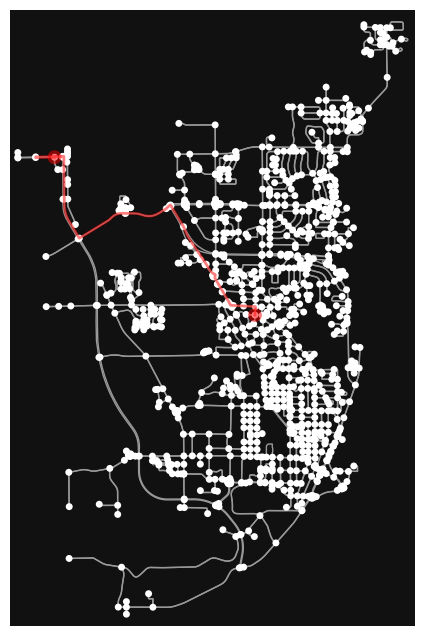

In [45]:
# Get the shortest path route
route = nx.shortest_path(graph, source=centroid_node, target=random_node, weight='travel_time')

# Plot the graph with the shortest path
fig, ax = ox.plot_graph_route(graph, route, node_size=25, route_linewidth=2, route_color='red')
plt.show()

## We can Use Folium for a More Interactive Map

#### fetching the lat/lon of the centroid by calculating mean of all the nodes in the area

In [91]:
# Extract node coordinates
nodes, _ = ox.graph_to_gdfs(graph)
centroid_lat = nodes['y'].mean()
centroid_lon = nodes['x'].mean()

centroid_node = ox.distance.nearest_nodes(graph, X=centroid_lon, Y=centroid_lat)

In [93]:
# Select a random node as the destination
random_node = np.random.choice(list(graph.nodes()))

# Compute the shortest path based on travel time
route = nx.shortest_path(graph, source=centroid_node, target=random_node, weight='travel_time')

In [95]:
# Convert graph to GeoDataFrames for folium plotting
nodes, edges = ox.graph_to_gdfs(graph)

# Create a folium map centered on the centroid
m = folium.Map(location=[centroid_lat, centroid_lon], zoom_start=13, tiles='CartoDB positron')

# Add all edges (roads) to the map
for _, edge in edges.iterrows():
    points = [(edge['geometry'].coords[i][1], edge['geometry'].coords[i][0]) for i in range(len(edge['geometry'].coords))]
    folium.PolyLine(points, color='gray', weight=2, opacity=0.7).add_to(m)

# Add the shortest path to the map
route_nodes = nodes.loc[route]
route_coords = [(row['y'], row['x']) for _, row in route_nodes.iterrows()]
folium.PolyLine(route_coords, color='red', weight=4, opacity=0.9).add_to(m)

# Add markers for centroid and random nodes
folium.Marker(
    location=[nodes.loc[centroid_node, 'y'], nodes.loc[centroid_node, 'x']],
    popup='Centroid Node',
    icon=folium.Icon(color='blue', icon='star')
).add_to(m)
folium.Marker(
    location=[nodes.loc[random_node, 'y'], nodes.loc[random_node, 'x']],
    popup='Random Node',
    icon=folium.Icon(color='green', icon='flag')
).add_to(m)

In [96]:
# Display the map
m

### If you want to Select a location of your Choice

In [99]:
# Replace with the coordinates from the map alerts
selected_coords = [[40.425, -86.908], [40.430, -86.900]]  # Example: Update with your selected coordinates

In [101]:
# Find nearest nodes to selected coordinates
start_node = ox.distance.nearest_nodes(graph, X=selected_coords[0][1], Y=selected_coords[0][0])
end_node = ox.distance.nearest_nodes(graph, X=selected_coords[1][1], Y=selected_coords[1][0])

In [103]:
# Compute shortest path
route = nx.shortest_path(graph, source=start_node, target=end_node, weight='travel_time')

In [106]:
# Convert graph to GeoDataFrames for folium plotting
nodes, edges = ox.graph_to_gdfs(graph)

# Create a folium map centered on the centroid
m = folium.Map(location=[centroid_lat, centroid_lon], zoom_start=13, tiles='CartoDB positron')

In [108]:
# Add all edges (roads) to the map
for _, edge in edges.iterrows():
    points = [(edge['geometry'].coords[i][1], edge['geometry'].coords[i][0]) for i in range(len(edge['geometry'].coords))]
    folium.PolyLine(points, color='gray', weight=2, opacity=0.7).add_to(m)

# Add the shortest path to the map
route_nodes = nodes.loc[route]
route_coords = [(row['y'], row['x']) for _, row in route_nodes.iterrows()]
folium.PolyLine(route_coords, color='red', weight=4, opacity=0.9).add_to(m)

In [109]:
m